In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
np.random.seed(42)

## 1. Visualization of data

In [3]:
# create ground truth function
X_truth = np.arange(0,10,0.1).reshape(100, 1)
y_truth = X_truth * np.sin(X_truth)

In [4]:
# simulate sampling
X = np.random.rand(10, 1) * 10
X = np.sort(X)

In [5]:
y = X * np.sin(X)

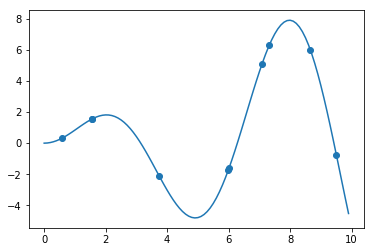

In [6]:
plt.scatter(X, y)
plt.plot(X_truth, y_truth)

## 2. Linear Regression

### 2-1. Derivation

Let $d$-dimensional input be $\mathrm{X}\in\mathbb{R}^{d \times n}$ and observation $\mathbf{y}\in\mathbb{R}^{n}$.

In **Linear Regression**, we predict $y$ linear function of $\mathbf{x}\in\mathbb{R}^{d}$ as 

$$\hat{y} = \mathbf{w}^{\mathsf{T}}\mathbf{x}+b,$$

where $\mathbf{w}\in\mathbb{R}^{d}$ and $b\in\mathbb{R}$ are coefficients of linear function.

Re-formulating $\mathbf{x}$ and $\mathbf{w}$ as $(d+1)$-dimensional vector and setting last dimension of $\mathbf{x}$ be 1
and last dimension of $\mathbf{w}$ be $b$, we get 

$$\hat{y}=\mathbf{w}^{\mathsf{T}}\mathbf{x}=\mathbf{x}^{\mathsf{T}}\mathbf{w}.\tag{1}$$

To express observation $\mathbf{y}$ using $\mathrm{X}$ better, we can interpret finding best $\mathbf{w}$ as optimization problem as:

$$
\begin{align}
    \hat{\mathbf{w}} &= \arg\min \|\mathbf{y}-\hat{\mathbf{y}}\|^2 \\
                     &:= \arg\min \|\mathbf{y}-\mathrm{X}^{\mathsf{T}}\mathbf{w}\|^2 \\
                     &= \arg\min (\mathbf{y}-\mathrm{X}^{\mathsf{T}}\mathbf{w})^{\mathsf{T}}
                                 (\mathbf{y}-\mathrm{X}^{\mathsf{T}}\mathbf{w}) \\
                     &= \arg\min \mathbf{w}^{\mathsf{T}}\mathrm{X}\mathrm{X}^{\mathsf{T}}\mathbf{w}
                                 -2\mathbf{w}^{\mathsf{T}}\mathrm{X}\mathbf{y} + \mathbf{y}^{\mathsf{T}}\mathbf{y}\tag{1}.
\end{align}
$$

Note that the shape of $\mathrm{X}$ is $(d+1) \times n$ and all components of $(d+1)$-th row of $\mathrm{X}$ are all one.

(2) is a simple quadratic function of $\mathbf{w}$, so we can minimize it by differentiating it and setting the differentiation zero:

$$
    \hat{\mathbf{w}} = (\mathrm{X}\mathrm{X}^{\top})^{-1}\mathrm{X}\mathbf{y}.
$$

After estimating $\hat{\mathbf{w}}$, we can predict output value of given input $\mathbf{x}$ using (1).

### 2-2. Implementation

In [167]:
class LinearRegressor():
    def __init__(self, biased=True):
        self.biased = biased
    
    def calc_XXT(self, X):
        return X@X.T
    
    def fit(self, X, y):
        dim, n_samp = X.shape
        assert y.shape == (n_samp, 1)
        if self.biased:
            X_ = np.concatenate((X, np.ones((1, n_samp))))
        else:
            X_ = X.copy()
        self.ndim = X_.shape[0]
        self.w = np.linalg.solve(self.calc_XXT(X_), X_@y)
        
    def predict(self, X):
        dim, n_samp = X.shape
        if self.biased:
            X_ = np.concatenate((X, np.ones((1, n_samp))))
        else:
            X_ = X.copy()
        assert self.ndim == X_.shape[0]
        return self.w.T @ X_

simple 1-dimensional (linear) regression

In [179]:
lr = LinearRegressor()

In [180]:
lr.fit(X.T, y)

In [181]:
y_pred = lr.predict(X_truth.reshape(1,100))

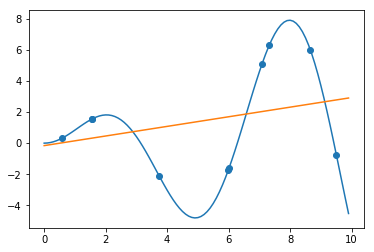

In [182]:
_=plt.scatter(X, y)
_=plt.plot(X_truth, y_truth)
_=plt.plot(X_truth, y_pred.T)

regression by 3- and 5-dimensional polynomials

In [196]:
X_3d = np.concatenate((X, X**2, X**3), axis=1)
X_5d = np.concatenate((X, X**2, X**3, X**4, X**5), axis=1)
X_truth_3d = np.concatenate((X_truth, X_truth**2, X_truth**3), axis=1)
X_truth_5d = np.concatenate((X_truth, X_truth**2, X_truth**3,
                             X_truth**4, X_truth**5), axis=1)

In [197]:
lr_3 = LinearRegressor()
lr_5 = LinearRegressor()

In [198]:
lr_3.fit(X_3d.T, y)
lr_5.fit(X_5d.T, y)

In [207]:
y_pred_3 = lr_3.predict(X_truth_3d.T)
y_pred_5 = lr_5.predict(X_truth_5d.T)

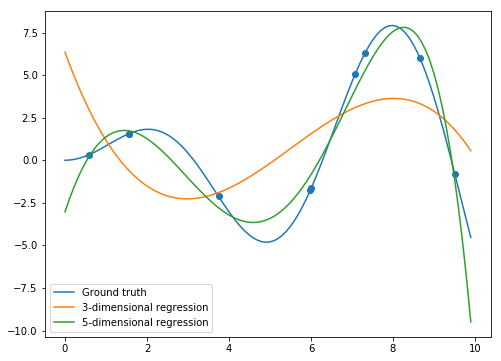

In [200]:
fig, ax = plt.subplots(figsize=(8,6))
ax.scatter(X, y)
ax.plot(X_truth, y_truth, label="Ground truth")
ax.plot(X_truth, y_pred_3.T, label="3-dimensional regression")
ax.plot(X_truth, y_pred_5.T, label="5-dimensional regression")
_ = ax.legend()

You can see overfitting at 7-dimensional regression.

In [201]:
print(lr_3.w)
print(lr_5.w)

[[-6.59915578]
 [ 1.51914967]
 [-0.09207848]
 [ 6.34365172]]
[[ 7.31371464e+00]
 [-3.17205737e+00]
 [ 2.22010504e-01]
 [ 4.54168928e-02]
 [-4.41293710e-03]
 [-3.03372339e+00]]


Coefficient for $x^3$ is larger in 7-dimensional model than in 3-dimensional model. This might be a cause of overfitting.

## 3. Ridge Regression

### 3-1. Derivation

For evade overfitting, we can introduce various penalty term for $\mathbf{w}$.
In Ridge regression, we introduce $L^2$ penalty as 

$$
\begin{align}
    \hat{\mathbf{w}} &= \arg\min \|\mathbf{y}-\hat{\mathbf{y}}\|^2 + \alpha\|\mathbf{w}\|^2\\
                     &= \arg\min \mathbf{w}^{\mathsf{T}}(\mathrm{X}\mathrm{X}^{\mathsf{T}}+\alpha\mathrm{I})\mathbf{w}
                                 -2\mathbf{w}^{\mathsf{T}}\mathrm{X}\mathbf{y} + \mathbf{y}^{\mathsf{T}}\mathbf{y}.\\
\end{align}
$$

Then, we can easily get optimum value of $\mathbf{w}$ in the same way:

$$\hat{\mathbf{w}} = (\mathrm{X}\mathrm{X}^{\mathsf{T}}+\alpha\mathrm{I})^{-1}\mathrm{X}\mathbf{y}.$$

### 3-2. Implementation

regression by 3- and 7-dimensional polynomials

In [202]:
class RidgeRegressor(LinearRegressor):
    def __init__(self, alpha=1e0, biased=True):
        super().__init__(biased)
        self.alpha=alpha
        
    def calc_XXT(self, X):
        return X@X.T + self.alpha * np.eye(self.ndim)

In [203]:
rr_5 = RidgeRegressor(alpha=5)

In [204]:
rr_5.fit(X_5d.T, y)

In [208]:
y_pred_5_ridge = rr_5.predict(X_truth_5d.T)

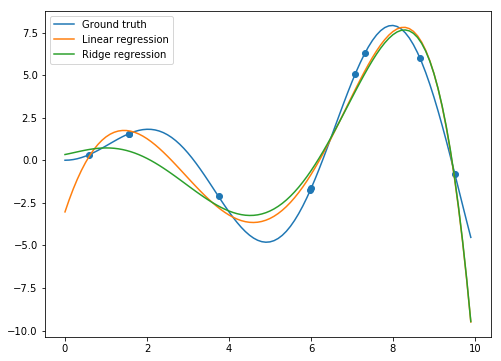

In [209]:
fig, ax = plt.subplots(figsize=(8,6))
ax.scatter(X, y)
ax.plot(X_truth, y_truth, label="Ground truth")
ax.plot(X_truth, y_pred_5.T, label="Linear regression")
ax.plot(X_truth, y_pred_5_ridge.T, label="Ridge regression")
_ = ax.legend()

Overfitting seems be more moderate.

In [210]:
print(lr_7.w)
print(rr_7.w)

[[ 7.31371464e+00]
 [-3.17205737e+00]
 [ 2.22010504e-01]
 [ 4.54168928e-02]
 [-4.41293710e-03]
 [-3.03372339e+00]]
[[ 0.46939396]
 [ 0.31005741]
 [-0.49586991]
 [ 0.11065865]
 [-0.00658981]
 [ 0.33572222]]


## 4. Gaussian Process Regression

### 4-1. Derivation

Linear regression and Ridge regression can be interpreted as maximum likelihood estimation under equi-variance Gaussian assumption:

$$
y \sim \mathcal{N}(\mathbf{w}^{\mathsf{T}}\mathbf{x}, \sigma^2).
$$

This is because MLE of $\mathbf{w}$ becomes as follows:

$$
\begin{align}
    \hat{\mathbf{w}}_{\mathrm{MLE}} &= \arg\max\sum_{i=1}^{n}\log p(y_i|\mathbf{x}_i)\\
                                    &= \arg\max_{\mathbf{w}}\sum_{i=1}^{n}\frac{-(y-\mathbf{w}^{\mathsf{T}}\mathbf{x})^2}{2\sigma^2} + \mathrm{const.},
\end{align}
$$ 

where $\mathrm{const.}$ includes terms independent of $\mathbf{w}$, which is equivalent to former formulation.

Important thing here is **homogeneity of variance**. It cannot express our intuition that `close input points output close values'.